# Demonstration book of WaveNet



This demonstration book will:
    
1. Define components in the model
2. Load pre-trained model and generate waveform samples


A few notes:
* There are many other open-sourced implementations of WaveNet. 
* WaveNet in this notebook is adopted from a [CUDA/C++ implementation](https://github.com/nii-yamagishilab/project-CURRENNT-scripts)
* Pytorch implementation here is quite slow compared with the CUDA/C++ one 
* Your contribution is welcome to improve it


Modules for WaveNet are defined in `../sandbox/block_wavenet.py`. For convenience, I copy the modules to this notebook and demonstrate the usage.

The project to train and run a WaveNet on CMU arctic database is available in `../project/05-nn-vocoder/wavenet`.


## 1. Define a WaveNet vocoder

I divide the model into four parts: 
* **waveform embedding**: convert discrete waveform values to embedding vectors
* **condition module**: process input features and do up-sampling
* **wavenet core**: dilated conv layers, gated activation ...
* **output module**: computes the categorical distribution for discrete waveform values

(By default, the picture below should look good. If not, please check whether it is displayed in monospace font)
```sh
Model during training phase

  -------------------------------------------------------------------------------  Wave
  |                                                                          -------|-------
  |                                                                          |      v      |
  |                                                                          |   Loss ()   |
  |                                                                          |      ^      |
  |                     ===================================================  |      | dist.|
  |                     | WaveNet core                                    |  |      |      |
  |                     |       -------------> + ---------------> + ------|->|output module|
  |                     |       |              ^                  ^       |  ---------------
  v                     |       |              |                  |       |  
           -----------  |  -----------    -----------        -----------  |
|z^-1| --> |embedding| --> |WNBlock 1| -> |WNBlock 2| -> ... |WNBlock N|  | 
           -----------  |  -----------    -----------        -----------  |
                        |       ^              ^                  ^       |
                        ========|==============|==================|========
                                |              |                  |
                                -----------------------------------
                    -----------                |
input_features -->  |condition| -> up-sampled_features
                    -----------
```

$z^{-1}$ denotes delay the feedback wave by 1 time step

WNBlock: WaveNet block with a dilated convolution layer, gated activation, and so on.

###  1.1. Preparation
Load some packages 

In [1]:
# load packages 
from __future__ import absolute_import
from __future__ import print_function
import os
import sys
import numpy as np
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

# basic nn blocks
import sandbox.block_nn as nii_nn
import sandbox.block_dist as nii_dist
import sandbox.util_dsp as nii_dsp

# misc functions for this demonstration book
#import plot_lib
import tool_lib
from plot_tools import plot_API
from plot_tools import plot_lib
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)


### 1.2 Waveform presentation & embedding

Original WaveNet treats waveform values as discrete symbols:   
```sh
waveform -> u-law companding -> quantization -> discrete values -> training target
```

It also possible to include pre-emphasis before $\mu$-law companding
```sh
waveform -> pre-emphasis -> u-law companding -> quantization -> discrete values -> training target
```

In this notebook we include pre-emphasis. Details of pre-emphasis and $\mu$-law companding are covered in `c10_waveform_tools`

In [2]:
# Let's load a waveform
wavfile_path = './data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav'
sampling_rate, wave_data = tool_lib.waveReadAsFloat(wavfile_path)

# convert it to tensor
# following the convention in c02_tensor_shape, we reshape it to (batch, length, 1)
wave_data_tensor = torch.tensor(wave_data, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

#### Companding and quantization

In [3]:
wave_data_preemph_tensor = torch.zeros_like(wave_data_tensor)

# Pre-emphasis H(z) = 1 - 0.97z^{-1}
with torch.no_grad():
    wave_data_preemph_tensor[:, 0, :] = wave_data_tensor[:, 0, :]
    wave_data_preemph_tensor[:, 1:, :] = wave_data_tensor[:, 1:, :] - 0.97 * wave_data_tensor[:, 0:-1, :]    

In [4]:
# mu-law compandign and quantization
#  this API is for pytorch tensor, but it is similar to the Numpy tool in c10_waveform_tools

# number of bits to quantize the waveform, there we use 10 bits
num_bits = 10
# i.e., the number of discrete waveform classes will be 2^10
num_classes = 2 ** num_bits

with torch.no_grad():
    # do mu-law compandign and quantization
    wave_data_quanized = nii_dsp.mulaw_encode(wave_data_preemph_tensor, num_classes)

(<Figure size 720x360 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe4190986a0>)

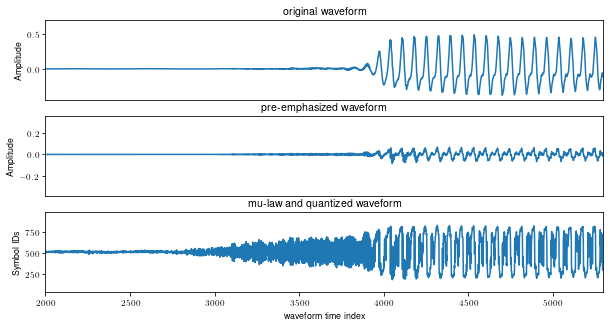

In [5]:
# Plot and check

plot_API.plot_API(
    [wave_data, wave_data_preemph_tensor[0, :, 0].numpy(), wave_data_quanized[0, :, 0].numpy()], 
    plot_lib.plot_signal,
    'v', 
    {'xlim': (2000, 5300), 
     'sub': [{'title': 'original waveform', 'ylabel': 'Amplitude'},
             {'title': 'pre-emphasized waveform', 'ylabel': 'Amplitude'},
             {'title': 'mu-law and quantized waveform', 'ylabel': 'Symbol IDs'}],
     'xlabel': 'waveform time index', 'sharex': True})

The pre-emphasized waveform looks quite different from original waveform in the time domain.

But in frequency domain, pre-emphasize just emphasize the high-frequecy band and change the spectrum tilt (see also the notebook `c10_waveform_tools`).

(<Figure size 720x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe3e94e09a0>)

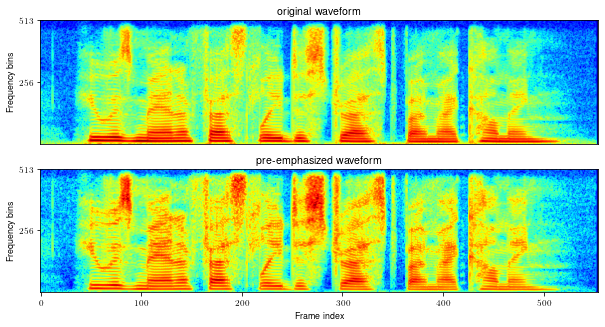

In [6]:
plot_API.plot_API(
    [wave_data, wave_data_preemph_tensor[0, :, 0].numpy()], 
    plot_lib.plot_spec,
    'v', 
    {'sub': [{'title': 'original waveform'},
             {'title': 'pre-emphasized waveform'}],
     'xlabel': 'Frame index', 'sharex': True})

#### Embedding


The quantized waveform are used at two places during model training:
* training target
* feedback input to WaveNet conv layers

For the 1st usage, we will cover it later. 

For the 2nd usage, it is a common practice to convert the quantized waveform symbols into a continuous-valued vector, i.e., $\mathbb{Z}\rightarrow \mathbb{R}^{D}$. Let's call it as embedding (the same idea as embedding vectors for natural language processing tasks). We simply use the Pytorch embedding API (https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).

```python
.
                          -----------   
wave discrete symbols --> |embedding| -->  embedding vectors
                          -----------  
```

Let's ignore the "feedback" and focus on embedding here

In [7]:
# dimension of embedding
embedding_dim = 64

# claim the embedding layer
l_wav_emb = torch_nn.Embedding(num_classes, embedding_dim)

# embedding
#.  note that wave_data_quanized has shape (batch, length, 1)
#   but Embedding expects (batch, length)
with torch.no_grad():
    waveform_embedding = l_wav_emb(wave_data_quanized.squeeze(-1))

# 
print("We have waveform embedding vectors in shape: %s" % (str(waveform_embedding.shape)))
print(" batch {:d}, length {:d}, dim {:d} ".format(
        *waveform_embedding.shape)) 

# check the embeddings for a few time steps
time_idices = [100, 200]
for time_idx in time_idices:
    print("\nFor waveform at time step {:d}:".format(time_idx))
    print("Quantized waveform value: {:d}".format(wave_data_quanized[0, time_idx, :].item()))
    print("Corresponding emebedding vector:\n", waveform_embedding[0, time_idx, :])

We have waveform embedding vectors in shape: torch.Size([1, 44241, 64])
 batch 1, length 44241, dim 64 

For waveform at time step 100:
Quantized waveform value: 527
Corresponding emebedding vector:
 tensor([-0.3907,  0.2075,  0.8805,  0.3958,  1.0445,  0.6495,  0.4193, -0.0676,
         0.9961, -0.3824,  1.3876, -2.0017, -0.5299, -0.9020, -1.9985,  0.9766,
        -0.8128,  0.6018,  0.4370, -1.4512, -1.0356,  0.1265,  0.7633,  1.5517,
         0.3942, -0.1815,  0.4455,  0.4110,  0.0044,  1.6076,  2.0148, -0.6879,
        -0.7451,  0.8506, -0.3848,  0.0910,  1.2057, -0.2777,  0.3974,  0.6612,
        -1.1605, -0.5940, -1.5142,  0.7785, -1.1781,  0.8507, -0.1808, -0.9317,
         0.7058,  1.1906,  1.1268, -1.0300,  0.7211, -0.3562, -0.8724, -0.7916,
         2.0840,  1.9076, -1.4828,  0.2986, -0.6295,  0.3628, -1.0111, -0.2404])

For waveform at time step 200:
Quantized waveform value: 536
Corresponding emebedding vector:
 tensor([-0.3895,  2.9528, -0.1985, -1.4376,  0.9426,  1.5954, -

#### Minor note

Rather than discrete symbols, waveform values can be modeled as continuous-valued numbers. Then the model uses Mixture-of-logistic (Oord 2018) or Gaussian (Ping 2019). I personally found Gaussian is reasonablly good (Wang 2019), but the Gaussian variance needs to be handled carefully. See page 44-51 of my slide `Neural waveform models for text-to-speech synthesis. 2019 Sep` on http://tonywangx.github.io/slide.html.

* van den Oord, A. et al. Parallel WaveNet: Fast high-fidelity speech synthesis. in Proc. ICML 3918–3926 (2018). 
* Ping, W., Peng, K. & Chen, J. ClariNet: Parallel wave generation in end-to-end text-to-speech. Proc. ICLR (2019). 
* Wang, X., Takaki, S. & Yamagishi, J. Neural Source-filter-based Waveform Model for Statistical Parametric Speech Synthesis. in Proc. ICASSP 5916–5920 (2019) 

### 1.3 Condition module

It transforms and up-samples the input acoustic features (e.g., Mel-spec)

Condition module can be designed in numerous ways. Here we use Bi-LSTM and simple duplication-based up-sampling.

```python
.
         ============================================
         | condition module                         |
         |  ---------    --------    -------------  |
c_1:M -> |  |Bi-LSTM| -> |conv1d| -> |Up-sampling|  |   -> \tilde{c}_{1:N}
         |  ---------    --------    -------------  |
         ============================================         
```

$\boldsymbol{c}_{1:M}$ denotes the input feature sequence with $M$ frames, and $\tilde{\boldsymbol{c}}_{1:N}$ denotes the up-sampled feature sequence of $N$. 

The $N$ is also the length of the target waveform, and $N = M \times \text{up-sampling-rate}$. For 16kHz waveform and input features extracted with frame-shift 5ms, the up-sampling rate is $80 = 16 * 5$

In [8]:
class CondModule(torch_nn.Module):
    """ Conditiona module: upsample and transform input features
    """
    def __init__(self, input_dim, output_dim, up_sample, \
                 blstm_s = 64, cnn_kernel_s = 3):
        """ CondModule(input_dim, output_dim, up_sample, 
        blstm_s=64, cnn_kernel_s=3)

        Args
        ----
          input_dim: int, input tensor should be (batchsize, len1, input_dim)
          output_dim: int, output tensor will be (batchsize, len2, output_dim)
          up_sample: int, up-sampling rate, len2 = len1 * up_sample
          
          blstm_s: int, layer size of the Bi-LSTM layer
          cnn_kernel_s: int, kernel size of the conv1d
        """
        super(CondModule, self).__init__()

        # configurations
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.up_sample = up_sample
        self.blstm_s = blstm_s
        self.cnn_kernel_s = cnn_kernel_s

        # layers
        self.l_blstm = nii_nn.BLSTMLayer(input_dim, self.blstm_s)
        self.l_conv1d = nii_nn.Conv1dKeepLength(
            self.blstm_s, output_dim, 1, self.cnn_kernel_s)
        self.l_upsamp = nii_nn.UpSampleLayer(
            self.output_dim, self.up_sample, True)

    def forward(self, feature):
        """ transformed_feat = forward(input_feature)

        input
        -----
          feature: (batchsize, length, input_dim)
        
        output
        ------
          transformed_feat: tensor (batchsize, length*up_sample, out_dim)
        """ 
        return self.l_upsamp(self.l_conv1d(self.l_blstm(feature)))


* `nii_nn.BLSTMLayer` is the Bi-LSTM layer covered in `c03_rnn_wrapper`;
* `nii_nn.Conv1dKeepLength` is the conv1d layered in `c04_conv1d_wrapper`;
* `nii_nn.UpsampleLayer` is the up-sampling layer with a optional moving-average filter. Moving average is covered in `c05_time_invariant_filtering` section 4;

All of them are defined in `../sandbox/block_nn.py`

You can of course replace the components with what you prefer.

But be aware of the shape of the input and output tensors (see `c02_tensor_shape`)

#### Example
Let's try some toy examples to show this module works

In [9]:
# Create an input feature matrix of size (batchsize, frame_length, feature_dim)
frame_length = 30
feature_dim = 16
batchsize = 2
input_feature = torch.rand(batchsize, frame_length, feature_dim)

# Initialzie a Condition module, which up-samples input feature for 80 times
# (80 = 16 kHz * 5 ms frame-shift)
output_dim = 16
up_sample = 80
m_cond = CondModule(feature_dim, output_dim, up_sample)

with torch.no_grad():
    feature_upsampled = m_cond(input_feature)


In [10]:
# Do a simple check
print("Input feature shape: %s" % (str(input_feature.shape)))
print("Output feature shape: %s" % (str(feature_upsampled.shape)))

print("Output feature batch {:d}, length {:d}, dim {:d} ".format(
        *feature_upsampled.shape))

Input feature shape: torch.Size([2, 30, 16])
Output feature shape: torch.Size([2, 2400, 16])
Output feature batch 2, length 2400, dim 16 


### 1.4 WaveNet core blocks

#### Single block

The core of WaveNet is a casacade of WaveNet core blocks.

Each block receives as input:
1. output of previous block or waveform embedding (if this is the 1st block)
2. condition features

Its output:

3. features used by output module
4. features used by the next block

The 3 and 4 are usually referred to as skip-channel and residual channgel respectively.
(Fig.4, van den Oord, A. et al. WaveNet: A Generative Model for Raw Audio. CoRR abs/1609.0, (2016))

```sh
.
          3
          ^         
          |         
     -----------    
1 -> |WNBlock k| -> 4
     -----------    
          ^
          |
          2
```     

Implementation of the WNBlock may be different. The common way is shown below. This is defined in `../sandbox/block_wavenet.py WaveNetBlock_V2`
```sh
.                                                        3            
                                                         ^                     
     ====================================================|================
     | WNBlock k                                         |               |
     | |-------------------------------------------------|---------      |
     | |                                                 |        |      |
     | |                                                 FC       |      |
     | |   ----------------               |-> tanh ->|   |        v      |
1 -> | ->  |dilated-conv1d| -> + -> split-|          x ---> FC -> + ------> 4
     |     ----------------    ^          |-> sig  ->|                   |
     |                         |                                         |
     |     ----------------    |                                         |
     |     |      FC      | ---|                                         |
     |     ----------------                                              |
     |            ^                                                      |
     =============|=======================================================
                  |
                  2

```

Here is the one used in this notebook, which I used for historical reason.
The skip-channel feature 3 is transformed from residual-channel feature 4.
This is defined in `../sandbox/block_wavenet.py WaveNetBlock`
```sh
.                                                                    3
                                                                     ^     
     ================================================================|====
     | WNBlock k                                                     |   |
     | |----------------------------------------------------------   |   |
     | |                                                         |   FC  |
     | |                                                         |   |   |
     | |   ----------------               |-> tanh ->|           v   |   |
1 -> | ->  |dilated-conv1d| -> + -> split-|          x --> FC -> + -------> 4
     |     ----------------    ^          |-> sig  ->|                   |
     |                         |                                         |
     |     ----------------    |                                         |
     |     |      FC      | ---|                                         |
     |     ----------------                                              |
     |            ^                                                      |
     =============|=======================================================
                  |
                  2
```


In [11]:
# Copy the module definition from sandbox.block_wavenet.WaveNetBlock


class WaveNetBlock(torch_nn.Module):
    """ WaveNet block based on dilated-1D, gated-activation, and skip-connect.
    Based on http://tonywangx.github.io/slide.html#misc CURRENNT WaveNet, 
    page 19-31.
    """
    def __init__(self, input_dim, skip_ch_dim, gated_act_dim, cond_dim,
                 dilation_size, cnn_kernel_size=2, causal=True):
        """ WaveNetBlock(input_dim, skip_ch_dim, gated_act_dim, cond_dim,
        dilation_size, cnn_kernel_size = 2)

        Args
        ----
          input_dim: int, input tensor should be (batch-size, length, input_dim)
                     this is the dimension of residual channel
          skip_ch_dim: int, tensors to be send to output blocks is in shape
                            (batch-size, length, skip_ch_dim)
          gated_act_dim: int, tensors given by tanh(.) * sig(.) is in shape
                            (batch-size, length, gated_act_dim)
          cond_dim: int, conditional feature (batchsize, length, cond_dim)

          dilation_size: int, dilation size of the conv
          cnn_kernel_size: int, kernel size of dilated conv1d (default, 2)
          causal: bool, whether this block is used in AR model (default, True)
        
        Note that causal==False will raise error if step-by-step generation
        is conducted by inference(input_feat, cond_feat, step_idx) with 
        step_idx != None. 
        For causal==False, always use inference(input_feat, cond_feat, None)
        """
        super(WaveNetBlock, self).__init__()

        #####
        # configurations
        #####
        # input tensor: (batchsize, length, self.input_dim)
        self.input_dim = input_dim
        # tensor sent to next WaveNetBlock, same shape as input
        self.res_ch_dim = input_dim
        # 
        self.skip_ch_dim = skip_ch_dim
        self.gated_act_dim = gated_act_dim
        self.cond_dim = cond_dim
        self.dilation_size = dilation_size
        self.conv_kernel_s = cnn_kernel_size

        ######
        # layers
        ######
        # dilated convolution
        self.l_conv1d = nii_nn.Conv1dForARModel(
            self.input_dim, self.gated_act_dim * 2, self.dilation_size,
            self.conv_kernel_s, tanh=False)
        
        # condition feature transform
        self.l_cond_trans = torch_nn.Sequential(
            torch_nn.Linear(self.cond_dim, self.gated_act_dim*2),
            torch_nn.LeakyReLU())
        
        # transformation after gated act
        self.l_res_trans = torch_nn.Linear(self.gated_act_dim, self.res_ch_dim)
        
        # transformation for skip channels
        self.l_skip_trans = torch_nn.Linear(self.res_ch_dim, self.skip_ch_dim)
        
        return

    def _forward(self, input_feat, cond_feat, step_idx=None):
        """ res_feat, skip_feat = forward(input_feat, cond_feat)
        
        input
        -----
          input_feat: input feature tensor, (batchsize, length, input_dim)
          cond_feat: condition feature tensor, (batchsize, length, cond_dim)
          step_idx: None: tranining phase
                    int: idx of the time step during step-by-step generation

        output
        ------
          res_feat: residual channel feat tensor, (batchsize, length, input_dim)
          skip_feat: skip channel feat tensor, , (batchsize, length, skip_dim)
        """
        # dilated 1d convolution
        hid = self.l_conv1d(input_feat, step_idx)

        # transform and add condition feature
        hid = hid + self.l_cond_trans(cond_feat)

        # gated activation
        hid = torch.tanh(hid[:, :, 0:self.gated_act_dim]) \
              * torch.sigmoid(hid[:, :, self.gated_act_dim:])

        # res-channel transform
        res_feat = self.l_res_trans(hid) + input_feat
        # skip-channel transform
        skip_feat = self.l_skip_trans(res_feat)

        # done
        return res_feat, skip_feat


    def forward(self, input_feat, cond_feat):
        """ res_feat, skip_feat = forward(input_feat, cond_feat)
        
        input
        -----
          input_feat: input feature tensor, (batchsize, length, input_dim)
          cond_feat: condition feature tensor, (batchsize, length, cond_dim)

        output
        ------
          res_feat: residual channel feat tensor, (batchsize, length, input_dim)
          skip_feat: skip channel feat tensor, , (batchsize, length, skip_dim)
        
        Note that input_dim refers to the residual channel dimension.
        Thus, input_feat should be embedding(audio), not audio.
        """
        return self._forward(input_feat, cond_feat)


    def inference(self, input_feat, cond_feat, step_idx):
        """ res_feat, skip_feat = inference(input_feat, cond_feat, step_idx)
        
        input
        -----
          input_feat: input feature tensor, (batchsize, length, input_dim)
          cond_feat: condition feature tensor, (batchsize, length, cond_dim)
          step_idx: int, idx of the time step during step-by-step generation

        output
        ------
          res_feat: residual channel feat tensor, (batchsize, length, input_dim)
          skip_feat: skip channel feat tensor, , (batchsize, length, skip_dim)
        """
        return self._forward(input_feat, cond_feat, step_idx)


The dilateted causal convolution layer `nii_nn.Conv1dForARModel` is based on the conv1d in c04_conv1d_wrapper. But it further addes the function for step by step generation (auto-regressive generation). 

Similarly, the WaveNet block has a `forward` method for training and a `inference` method for auto-regressive generation. We will talk about auto-regressive generation later.


For now, let's just try some examples

In [12]:
# input dimension is set as the dimension of residual channel 
input_dim = 16
# condition feature dim
cond_dim = 16
# skip channel dimension
skip_ch_dim = 32
# gated activation dimension
gated_act_dim = 32
# dilation size
dilation_size = 2

m_wnblock = WaveNetBlock(input_dim, skip_ch_dim, gated_act_dim, cond_dim, dilation_size)

In [13]:
batch = 2
length = 100

input_feat = torch.randn([batch, length, input_dim])
cond_feat = torch.randn([batch, length, cond_dim])


with torch.no_grad():
    res_feat, skip_feat = m_wnblock(input_feat, cond_feat)
    
print("Input feature batch     {:d}, length {:d}, dim {:d} ".format(*input_feat.shape))
print("Condition feature batch {:d}, length {:d}, dim {:d} ".format(*cond_feat.shape))

print("\nResidual-channel feature batch {:d}, length {:d}, dim {:d} ".format(*res_feat.shape))
print("Skip-channel feature     batch {:d}, length {:d}, dim {:d} ".format(*skip_feat.shape))

Input feature batch     2, length 100, dim 16 
Condition feature batch 2, length 100, dim 16 

Residual-channel feature batch 2, length 100, dim 16 
Skip-channel feature     batch 2, length 100, dim 32 


#### Connecting multiple blocks

Connecting multiple blocks is straightforward
```sh
.
      ===================================================  
      | WaveNet core                                    |  
      |       -------------> + ---------------> + ------|-> output_feature
      |       |              ^                  ^       |  
      |       |              |                  |       |  
      |  -----------    -----------        -----------  |
Input--> |WNBlock 1| -> |WNBlock 2| -> ... |WNBlock N|  | 
      |  -----------    -----------        -----------  |
      |       ^              ^                  ^       |
      ========|==============|==================|========
              |              |                  |
              ---------------|-------------------
             up-sampled condition features
```

Input will be the output from embedding layers.  Condition features willbe the up-sampled condition features. 

In [14]:
# Let's try one definition
#
# number of blocks
num_blocks = 5

# re-use the configuration above
m_wnblocks = []
for idx in range(num_blocks):
    dilation_size = 2 ** idx
    print("Create WaveNet block with dilation size {:d}".format(dilation_size))
    m_wnblocks.append(WaveNetBlock(input_dim, skip_ch_dim, gated_act_dim, cond_dim, dilation_size))
m_wnblocks = torch_nn.ModuleList(m_wnblocks)


def WaveNetCore(wnblocks, input_feat, cond_feat):
    
    #  buffer to save skip-channel features
    skip_ch_feat = torch.zeros(
        [input_feat.shape[0], input_feat.shape[1], skip_ch_dim],
        device=input_feat.device, dtype=input_feat.dtype)

    # start the loop
    #  residual channel feature
    res_ch_feat = input_feat
    for l_wavblock in wnblocks:
        # notice that the residual feature is added with input inside the WaveNet block
        # thus, here we directly use the output res_ch_feat as input to the next block
        res_ch_feat, tmp_skip_ch_feat = l_wavblock(res_ch_feat, cond_feat)
        skip_ch_feat += tmp_skip_ch_feat
    
    return skip_ch_feat


Create WaveNet block with dilation size 1
Create WaveNet block with dilation size 2
Create WaveNet block with dilation size 4
Create WaveNet block with dilation size 8
Create WaveNet block with dilation size 16


In [15]:
with torch.no_grad():
    output_feature = WaveNetCore(m_wnblocks, input_feat, cond_feat)
    
print("Input feature          batch {:d}, length {:d}, dim {:d} ".format(*input_feat.shape))
print("Condition feature      batch {:d}, length {:d}, dim {:d} ".format(*cond_feat.shape))

print("\bOutput_feature         batch {:d}, length {:d}, dim {:d} ".format(*output_feature.shape))

Input feature          batch 2, length 100, dim 16 
Condition feature      batch 2, length 100, dim 16 
Output_feature         batch 2, length 100, dim 32 


### 1.5 Output module

The Output module receives the WaveNet core module's output, then
* during training, it evaluates the model likelihood given target waveform
* during generation, it outputs a waveform sample for each time step

Note again that waveform is modeled as discrete symbol in this notebook. 

**During training**

The Output module changes the dimension of input feature dimension, computes the categorical distribution for each waveform symbol, and evaluate the cross-entropy. 

Here we use Pytorch API https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.
No need to use softmax after the logits because this API will do that for us.

The FC layers are used to change the dimension of features.

```sh
.
                        ============================================
                        | output module                            |
                        | ----------------                         |
Output_of_skipchannel ->| |FC + LeakyReLU| -> ... -> logits -> CrossEntropyLoss() <---- Target_waveform
   (B, T, D)            | ----------------          (B, T, M)      |                     (B, T, 1)
                        ============================================        
```
The shape of input is (Batch, temporal length, dimension)

The shape of logits is (Batch, temporal length, number_of_waveform_qunatization_levels)

The target waveform can be (Batch, temporal length, 1)

**During generation**

Just convert the logits into the Catogreical distribution and draw a sample
```sh
.
                        ===========================================================
                        | output module                                           |
                        | ----------------                                        |
Output_of_skipchannel ->| |FC + LeakyReLU| -> ... -> logits -> Softmax() -> Dist. ->    Sample
   (B, 1, D)            | ----------------          (B, 1, M)                     |   (B, 1, 1)
                        ===========================================================
```
Of course, T samples can be drawn if the input has shpe (B, T, D).

Fro convenience, we wrap the CrossEntropyLoss() and sampling process into `../sandbox/block_dist.py DistCategorical`. We will not explain it here.

In [16]:
class OutputBlock(torch_nn.Module):
    """Output block to produce waveform distribution given skip-channel features
    """
    def __init__(self, input_dim, output_dim, hid_dim=512):
        """ OutputBlock(input_dim, output_dim)
        
        Args
        ----
          input_dim: int, input tensor should be (batchsize, length, input_dim)
                     it should be the sum of skip-channel features
          output_dim: int, output tensor will be (batchsize, length, output_dim)
          hid_dim: int, dimension of intermediate linear layers
        """
        super(OutputBlock, self).__init__()

        # config
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim

        # transformation layers before softmax
        self.l_trans = torch_nn.Sequential(
            torch_nn.Linear(self.input_dim, self.hid_dim // 2),
            torch_nn.LeakyReLU(),
            torch_nn.Linear(self.hid_dim // 2, self.hid_dim),
            torch_nn.LeakyReLU(),
            torch_nn.Linear(self.hid_dim, self.output_dim))

        # output distribution
        self.l_dist = nii_dist.DistCategorical(self.output_dim)
        
        return
        
    def forward(self, input_feat, target):
        """loss = forward(input_feat, target) 
        This method is supposed to be used to compute the loss

        input
        -----
          input_feat: tensor in shape (batchsize, length, input_dim)
          target: waveform tensor in shape (batchsize, length, dim=1)
        
        output
        ------
          loss: tensor or scalar
        """
        # transform hidden feature vector to logit
        tmp_logit = self.l_trans(input_feat)
        # calculate the likelihood
        return self.l_dist(tmp_logit, target)

    def inference(self, input_feat):
        """output = inference(input_feat)

        input
        -----
          input_feat: tensor in shape (batchsize, length, input_dim)

        output
        ------
          target: waveform tensor in shape (batchsize, length, dim=1)
        """
        # transform hidden feature vector to logit
        tmp_logit = self.l_trans(input_feat)
        return self.l_dist.inference(tmp_logit)
        


In [17]:
# Example

# output_class
num_output_classes = 256

# dimension of input (i.e., dimension of the Wavenet skip-channel)
input_dim = 32

# claim one output module
m_output = OutputBlock(input_dim, num_output_classes)

In [18]:
# During training
# 
# input data
batch = 2
length = 100
input_feat = torch.randn([batch, length, input_dim])

# target (just random integers)
target_waveform = torch.rand([batch, length, 1]) * num_output_classes
# it must be long
target_waveform = target_waveform.to(torch.int64)

with torch.no_grad():
    loss = m_output(input_feat, target_waveform)
    
print("Input feature   batch {:d}, length {:d}, dim {:d} ".format(*input_feat.shape))
print("Target waveform batch {:d}, length {:d}, dim {:d} ".format(*target_waveform.shape))

Input feature   batch 2, length 100, dim 32 
Target waveform batch 2, length 100, dim 1 


In [19]:
# During generation
# 
# input data
batch = 2
# here we only try generation for one time step
length = 1
input_feat = torch.randn([batch, length, input_dim])

with torch.no_grad():
    gen_wave = m_output.inference(input_feat)
    
print("Input feature      batch {:d}, length {:d}, dim {:d} ".format(*input_feat.shape))
print("Generated waveform batch {:d}, length {:d}, dim {:d} ".format(*gen_wave.shape))

Input feature      batch 2, length 1, dim 32 
Generated waveform batch 2, length 1, dim 1 


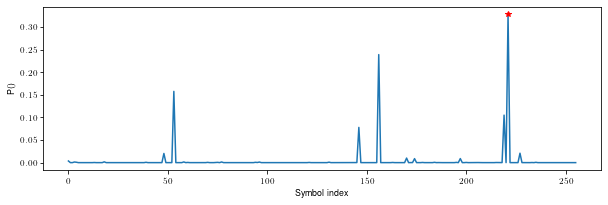

In [20]:
# To look inside the generation process (some of the code are in sandbox/block_dist DistCategorical)
#
# compute the probablity vector
with torch.no_grad():
    # get the logits
    logits = m_output.l_trans(input_feat)
    
    # for visualization, let's sharpen the distribution
    #.  this is also used in some models.
    #.  let's use a very large value
    logits = logits * 50
    
    prob_vec = torch_nn_func.softmax(logits, dim=2)
    # wrap around the categorical distribution
    distrib = torch.distributions.Categorical(prob_vec)
    # draw sample
    sample = distrib.sample()

# plot the figure for one batch
batch_idx = 0
sample = np.array(sample.numpy(), dtype=np.int32)

fig = plt.figure(figsize=(10,3))
axis = fig.add_subplot(111)
axis.plot(prob_vec[batch_idx, 0].numpy())
axis.set_xlabel('Symbol index');
axis.set_ylabel('P()');
axis.plot(sample[batch_idx], prob_vec[batch_idx, 0, sample[batch_idx]].numpy(), color='r', marker='*')

## 1.6 Put components together

All the components have been explained. 

The full definition of one WaveNet model is given in `../sandbix/block_wavenet.py WaveNet_v1`.

For convenience, we copy the model definition here

In [21]:
class WaveNet_v1(torch_nn.Module):
    """ Model definition of WaveNet
    Example definition of WaveNet, version 1

    """
    def __init__(self, in_dim, up_sample_rate, num_bits = 10, wnblock_ver=1,
                 pre_emphasis=True):
        """ WaveNet(in_dim, up_sample_rate, num_bits=10, wnblock_ver=1,
        pre_emphasis=False)
        
        Args
        ----
          in_dim: int, dimension of condition feature (batch, length, in_dim)
          up_sample_rate, int, condition feature will be up-sampled by
                   using this rate
          num_bits: int, number of bits for mu-law companding, default 10
          wnblock_ver: int, version of the WaveNet Block, default 1
                       wnblock_ver = 1 uses WaveNetBlock
                       wnblock_ver = 2 uses WaveNetBlock_v2
          pre_emphasis: bool, whether use pre-emphasis on the target waveform

        up_sample_rate can be calculated using frame_shift of condition feature
        and waveform sampling rate. For example, 16kHz waveform, condition
        feature (e.g., Mel-spectrogram) extracted using 5ms frame shift, then
        up_sample_rate = 16000 * 0.005 = 80. In other words, every frame will
        be replicated 80 times.
        """
        super(WaveNet_v1, self).__init__()
        
        #################
        ## model config
        #################
        # number of bits for mu-law
        self.num_bits = num_bits
        self.num_classes = 2 ** self.num_bits
        
        # up-sample rate
        self.up_sample = up_sample_rate
        
        # wavenet blocks
        #  residual channel dim
        self.res_ch_dim = 64
        #  gated activate dim
        self.gate_act_dim = 64
        #  condition feature dim
        self.cond_dim = 64
        #  skip channel dim
        self.skip_ch_dim = 256
        #  dilation size
        self.dilations = [2 ** (x % 10) for x in range(30)]
        
        # input dimension of (conditional feature)
        self.input_dim = in_dim
        
        # version of wavenet block
        self.wnblock_ver = wnblock_ver

        # whether pre-emphasis
        self.pre_emphasis = pre_emphasis
        ###############
        ## network definition
        ###############
        # condition module
        self.l_cond = CondModule(self.input_dim, self.cond_dim, self.up_sample)
        
        # waveform embedding layer 
        self.l_wav_emb = torch_nn.Embedding(self.num_classes, self.res_ch_dim)

        # dilated convolution layers
        tmp_wav_blocks = []
        for dilation in self.dilations:
            if self.wnblock_ver == 2:
                tmp_wav_blocks.append(
                    WaveNetBlock_v2(
                        self.res_ch_dim, self.skip_ch_dim, self.gate_act_dim,
                        self.cond_dim, dilation))
            else:
                tmp_wav_blocks.append(
                    WaveNetBlock(
                        self.res_ch_dim, self.skip_ch_dim, self.gate_act_dim,
                        self.cond_dim, dilation))
        self.l_wavenet_blocks = torch_nn.ModuleList(tmp_wav_blocks)
        
        # output block
        self.l_output = OutputBlock(self.skip_ch_dim, self.num_classes)
        
        # done
        return
    
    def _waveform_encode_target(self, target_wav):
        return nii_dsp.mulaw_encode(target_wav, self.num_classes)

    def _waveform_decode_target(self, gen_wav):
        return nii_dsp.mulaw_decode(gen_wav, self.num_classes)

    def forward(self, input_feat, wav):
        """loss = forward(self, input_feat, wav)

        input
        -----
          input_feat: tensor, input features (batchsize, length1, input_dim)
          wav: tensor, target waveform (batchsize, length2, 1)
               it should be raw waveform, flot valued, between (-1, 1)
               it will be companded using mu-law automatically
        output
        ------
          loss: tensor / scalar
        
        Note: returned loss can be directly used as the loss value
        no need to write Loss()
        """
        
        # step1. prepare the target waveform and feedback waveform
        #  do mu-law companding
        #  shifting by 1 time step for feedback waveform
        with torch.no_grad():
            if self.pre_emphasis:
                wav[:, 1:, :] = wav[:, 1:, :] - 0.97 * wav[:, 0:-1, :]

            # mu-law companding (int values)
            # note that _waveform_encoder_target will produce int values
            target_wav = self._waveform_encode_target(wav)
            
            # feedback wav
            fb_wav = torch.zeros(
                target_wav.shape, device=wav.device, dtype=target_wav.dtype)
            fb_wav[:, 1:] = target_wav[:, :-1]
        
        # step2. condition feature
        hid_cond = self.l_cond(input_feat)

        # step3. feedback waveform embedding
        hid_wav_emb = self.l_wav_emb(fb_wav.squeeze(-1))

        # step4. stacks of wavenet
        #  buffer to save skip-channel features
        skip_ch_feat = torch.zeros(
            [target_wav.shape[0],target_wav.shape[1], self.skip_ch_dim],
            device=input_feat.device, dtype=input_feat.dtype)
        
        res_ch_feat = hid_wav_emb
        for l_wavblock in self.l_wavenet_blocks:
            res_ch_feat, tmp_skip_ch_feat = l_wavblock(res_ch_feat, hid_cond)
            skip_ch_feat += tmp_skip_ch_feat
        
        # step5. get output
        likelihood = self.l_output(skip_ch_feat, target_wav)

        return likelihood

    def inference(self, input_feat):
        """wav = inference(mels)

        input
        -----
          input_feat: tensor, input features (batchsize, length1, input_dim)

        output
        ------
          wav: tensor, target waveform (batchsize, length2, 1)

        Note: length2 will be = length1 * self.up_sample
        """        

        # prepare
        batchsize = input_feat.shape[0]
        wavlength = input_feat.shape[1] * self.up_sample
        
        time_idx_marker = wavlength // 10
        #
        # step1. condition features
        hid_cond = self.l_cond(input_feat)

        # step2. do computation step-by-step
        # initialzie the buffer
        gen_wav_buf = torch.zeros(
            [batchsize, wavlength, 1], 
            dtype=input_feat.dtype, device=input_feat.device)

        fb_wav_buf = torch.zeros(
            [batchsize, 1, 1], 
            dtype=input_feat.dtype, device=input_feat.device)

        skip_ch_feat = torch.zeros(
            [batchsize, 1, self.skip_ch_dim],
            dtype=input_feat.dtype, device=input_feat.device)

        # loop over all time steps
        print("Total time steps: {:d}. Progress: ".format(wavlength), 
              end=' ', flush=True)
        for time_idx in range(wavlength):
            # show messages
            if time_idx % 500 == 1:
                print(time_idx, end=' ', flush=True) 

            # feedback
            if time_idx > 0:
                fb_wav_buf = gen_wav_buf[:, time_idx-1:time_idx, :]
                
            # initialize skip
            skip_ch_feat *= 0

            # embedding
            hid_wav_emb = self.l_wav_emb(fb_wav_buf.squeeze(-1).to(torch.int64))

            # condition feature for current time step
            #  for other time steps, intermediate feat is saved by wave blocks
            hid_cond_tmp = hid_cond[:, time_idx:time_idx+1, :]

            # loop over wavblocks
            res_ch_feat = hid_wav_emb
            for l_wavblock in self.l_wavenet_blocks:
                res_ch_feat, tmp_skip_ch_feat = l_wavblock.inference(
                    res_ch_feat, hid_cond_tmp, time_idx)
                skip_ch_feat += tmp_skip_ch_feat

            # draw sample
            drawn_sample = self.l_output.inference(skip_ch_feat)
            gen_wav_buf[:, time_idx:time_idx+1, :] = drawn_sample


        # decode mu-law
        wave = self._waveform_decode_target(gen_wav_buf)
         
        # de-emphasis if necessary
        if self.pre_emphasis:
            for idx in range(wave.shape[1] - 1):
                wave[:, idx+1, :] = wave[:, idx+1, :] + 0.97 * wave[:, idx, :]
        return wave


Notice that this `WaveNet_v1` includes pre-emphasis and de-emphasis.

You can choose whether use WaveNet block version 1 or 2.

## 2. Using pre-trained model for waveform generation

Here we load pre-trained Wavenet_v1 model and generate a sample.


### 2.1 Meta-Model wrapper

For my pytorch script, I further wrap around the `WaveNet_v1` with a meta-model Module. This is convenient for methods irrelavant to a specific model, for example, input and output feature normalization.

This is merely a practice. Nothing new for WaveNet.

In [22]:

# A template meta model wrapper
#
#.  WaveNet_v1 is included as self.m_wavenet
# 
class Model(torch_nn.Module):
    """ Model definition
    """
    def __init__(self, in_dim, out_dim, args, prj_conf, mean_std=None):
        super(Model, self).__init__()

        #################
        ## must-have
        #################
        # mean std of input and output
        in_m, in_s, out_m, out_s = self.prepare_mean_std(in_dim,out_dim,\
                                                         args, mean_std)
        self.input_mean = torch_nn.Parameter(in_m, requires_grad=False)
        self.input_std = torch_nn.Parameter(in_s, requires_grad=False)
        self.output_mean = torch_nn.Parameter(out_m, requires_grad=False)
        self.output_std = torch_nn.Parameter(out_s, requires_grad=False)
        self.input_dim = in_dim
        self.output_dim = out_dim
        
        # a flag for debugging (by default False)    
        self.model_debug = False
        
        #################
        ## model config
        #################
        # number of bits for mu-law
        self.num_bits = 10
        
        # Up-sampling rate is 80 for this model
        #  in my Pytorch script, this should be loaded from prj_conf
        #self.up_sample = prj_conf.input_reso[0]
        self.up_sample = 80
        
        # model 
        # Most of the configurations are fixed in sandbox.block_wavenet.py
        self.m_wavenet = WaveNet_v1(in_dim, self.up_sample, self.num_bits)
        
        # done
        return
    
    def prepare_mean_std(self, in_dim, out_dim, args, data_mean_std=None):
        """
        """
        if data_mean_std is not None:
            in_m = torch.from_numpy(data_mean_std[0])
            in_s = torch.from_numpy(data_mean_std[1])
            out_m = torch.from_numpy(data_mean_std[2])
            out_s = torch.from_numpy(data_mean_std[3])
            if in_m.shape[0] != in_dim or in_s.shape[0] != in_dim:
                print("Input dim: {:d}".format(in_dim))
                print("Mean dim: {:d}".format(in_m.shape[0]))
                print("Std dim: {:d}".format(in_s.shape[0]))
                print("Input dimension incompatible")
                sys.exit(1)
            if out_m.shape[0] != out_dim or out_s.shape[0] != out_dim:
                print("Output dim: {:d}".format(out_dim))
                print("Mean dim: {:d}".format(out_m.shape[0]))
                print("Std dim: {:d}".format(out_s.shape[0]))
                print("Output dimension incompatible")
                sys.exit(1)
        else:
            in_m = torch.zeros([in_dim])
            in_s = torch.ones([in_dim])
            out_m = torch.zeros([out_dim])
            out_s = torch.ones([out_dim])
            
        return in_m, in_s, out_m, out_s
        
    def normalize_input(self, x):
        """ normalizing the input data
        """
        return (x - self.input_mean) / self.input_std

    def normalize_target(self, y):
        """ normalizing the target data
        """
        return (y - self.output_mean) / self.output_std

    def denormalize_output(self, y):
        """ denormalizing the generated output from network
        """
        return y * self.output_std + self.output_mean

    def _waveform_encode_target(self, target_wav):
        return nii_dsp.mulaw_encode(target_wav, self.num_classes)

    def _waveform_decode_target(self, gen_wav):
        return nii_dsp.mulaw_decode(gen_wav, self.num_classes)

    def forward(self, input_feat, wav):
        """loss = forward(self, input_feat, wav)

        input
        -----
          input_feat: tensor, input features (batchsize, length1, input_dim)
          wav: tensor, target waveform (batchsize, length2, 1)
               it should be raw waveform, flot valued, between (-1, 1)
               the code will do mu-law conversion
        output
        ------
          loss: tensor / scalar
        
        Note: returned loss can be directly used as the loss value
        no need to write Loss()
        """
        # normalize input features
        input_feat = self.normalize_input(input_feat)
        # compute cross-entropy using wavenet
        return self.m_wavenet.forward(input_feat, wav)

    def inference(self, input_feat):
        """wav = inference(mels)

        input
        -----
          input_feat: tensor, input features (batchsize, length1, input_dim)

        output
        ------
          wav: tensor, target waveform (batchsize, length2, 1)

        Note: length2 will be = length1 * self.up_sample
        """
        # normalize the input
        input_feat = self.normalize_input(input_feat)
        # get the output waveform
        wave = self.m_wavenet.inference(input_feat)
        return wave

In [23]:
# input feature dim (80 dimension Mel-spec)
mel_dim = 80
input_dim = mel_dim

# output dimension = 1 for waveform
output_dim = 1
# sampling rate of waveform (Hz)
sampling_rate = 16000


# declare the model
m_wavenet = Model(input_dim, output_dim, None, None)

In [24]:
# load pre-trained model
device=torch.device("cpu")
m_wavenet.to(device, dtype=torch.float32)

pretrained_file = "data_models/pre_trained_wavenet/__pre_trained/trained_network.pt"
if os.path.isfile(pretrained_file):
    checkpoint = torch.load(pretrained_file, map_location="cpu")
    m_wavenet.load_state_dict(checkpoint)
else:
    print("Cannot find pre-trained model {:s}".format(pretrained_file))
    print("Please run 00_download_model.sh and download the pre-trained model")

### 2.2 Load waveform, extract input features, and generate waveform

Just for "quick" demonstration, let's generate a short segment of waveform.

Let's use CPU.

#### Extract input features

In [25]:
# If you want to do copy-synthesis
# The tools to extract are in data_models/scripts
import sys
import os
import data_models.scripts.sub_get_mel as nii_mel_tk

sampling_rate = 16000
fftl_n = 1024
frame_length = 400
# This must be compatible with the WaveNet up-sampling rate configuration
frame_shift = 80
frame_length_in_ms = int(frame_length*1000/sampling_rate)
frame_shift_in_ms = int(frame_shift*1000/sampling_rate)

# Use waveform from this folder
input_waveform_path = "data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav"
input_mel = nii_mel_tk.get_melsp(input_waveform_path, fftl=fftl_n, fl=frame_length, fs=frame_shift)

# If you have problem running the code above, please just load the pre-extracted features
# mel_dim = 80
#input_mel = tool_lib.read_raw_mat("data_models/acoustic_features/hn_nsf/slt_arctic_b0474.mfbsp", mel_dim)

# trim the mel for quick demonstration
input_mel = input_mel[:290, :]

In [26]:
print("Input Mel shape:" + str(input_mel.shape))
# compose the input tensor
input_tensor = torch.tensor(input_mel, dtype=torch.float32).unsqueeze(0)
print("Input data tensor shape:" + str(input_tensor.shape))

Input Mel shape:(290, 80)
Input data tensor shape:torch.Size([1, 290, 80])


#### Generate waveform
This may be slow. The **Progress** message will show the number of waveform samples generated. 

Please be patient! If it is too slow, please reduce the length of input mel-spec further.

In [27]:
with torch.no_grad():
    output_waveform = m_wavenet.inference(input_tensor)

Total time steps: 23200. Progress:  1 501 1001 1501 2001 2501 3001 3501 4001 4501 5001 5501 6001 6501 7001 7501 8001 8501 9001 9501 10001 10501 11001 11501 12001 12501 13001 13501 14001 14501 15001 15501 16001 16501 17001 17501 18001 18501 19001 19501 20001 20501 21001 21501 22001 22501 23001 

In [28]:
import IPython.display
IPython.display.Audio(output_waveform[0, :, 0].numpy(), rate=sampling_rate, normalize=False)

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe4199bc8e0>)

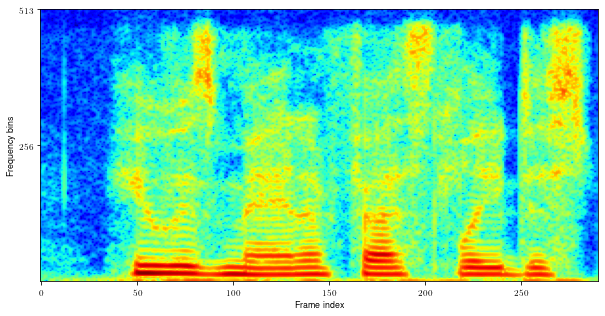

In [29]:
# plot the spectrogram of the generated waveform
plot_API.plot_API(output_waveform[0, :, 0].numpy(), plot_lib.plot_spec, 'single')

You can try to generate the full utterance by commenting out this line when preparing the input Mel-spectrogram
```sh
# trim the mel for quick demonstration
input_mel = input_mel[:290, :]
```

You may also try to extract Mel-spectrogram from other waveforms in `data_models/acoustic_features/hn_nsf`.


Note that waveforms I used to train this WaveNet have normalized  amplitude. The normalization tool is the sv56 https://github.com/openitu/STL. If you try part3 of this tutorial and run the script `../project/05-nn-vocoders/wavenet/00_demo.sh`, you will download the normalized waveforms of CMU-arctic. There will also be a script to use sv56 `../project/05-nn-vocoders/DATA/cmu-arctic-data-set/scripts/wav`. But please compile the sv56 and sox first. 

## 3. On generation

(This is based on a very old slide. Page 50 - 56 of slide `CURRENNT WaveNet` on [this page](http://tonywangx.github.io/slide.html))

There was a pioneering paper called FastWaveNet https://arxiv.org/abs/1611.09482 on this topic.

If you already read it, feel free to skip this section.

### Motivation

WaveNet works differently in training and generation: in training, we give a input tensor of shape (batch, length, dimension), and the network do the forward computation for time steps simultaneously; in generation, we have to produce waveform one by one, i.e., waveform output of the current time step depends on the previous steps. 

Accordignly, modules in the WaveNet needs two working modes:

* **forward()** for training: given input in shape (batch, length, dimension), compute output (batch, length, dimension)
* **inference()** for generation: given input in shape (batch, length=1, dimension) and past feature if necessary, compute output (batch, length=1, dimension)

Luckily, only the dilated convolution layers requires information from previous steps during **inference()**. 
Other modules such as FC can use the exactly same method for both **forward()** and **inference()**. 

Therefore, here we focus on the Convolution layers.

Suppose two causal conv layers with a kernel size 2. Given input $(z_1, z_2, \cdots)$, we first generate $(x_1, x_2, \cdots)$, then we generate the output $(y_1, y_2, \cdots)$ 

```sh
step1         step2         step3                step4                  step5    
y[1]           y[2]           y[3]                 y[4]                   y[5]          
 |              |           /    |              /     |               /     |          
 |              |          /     |             /      |              /      |      dilation 2
 |              |         /      |            /       |             /       |          
x[1]           x[2]    x[1]    x[3]        x[2]      x[4]         x[3]     x[5]      
 |             /|        |      /|         /|        /|           /|       /|      
 |            / |        |     / |        / |       / |          / |      / |     dilation 1
 |           /  |        |    /  |       /  |      /  |         /  |     /  |      
z[1]      z[1] z[2]    z[1] z[2] z[3]  z[1] z[2] z[3] z[4]   z[2] z[3] z[4] z[5]   
```

### Some ideas

**Naive implementation** -- no cache

```sh
for step1, x[1] <- conv(z[1], 0),    
           y[1] <- conv(x[1], 0)

for step2, x[2] <- conv(z[2], z[1]), 
           y[2] <- conv(x[2], 0)

for step3, x[1] <- conv(z[1], 0), 
           x[3] <- conv(z[3], z[2]), 
           y[3] <- conv(x[3], x[1])
           
for step4, x[2] <- conv(z[2], z[1]), 
           x[4] <- conv(z[4], z[3]), 
           y[4] <- conv(x[4], x[2])
           
...
```

Suppose we have $L$ conv layers, for each step, we need to compute node in the dependency graph.

The number of conv() operation required depends on $L$ and the kernel size $K$, and is $\sum_i^L K^{L-1}$.

Notice that x[1] is computed for step 1 and 3, and x[2] is used in step 2 and 4. If we cache the intermediate steps in memory, we can avoid some of the computations.

**Memory hungry implementation** -- cache them all

```sh
for step1, x[1] <- conv(z[1], 0)
           y[1] <- conv(x[1], 0)
           save x[1]
           
for step2, x[2] <- conv(z[2], z[1])
           y[2] <- conv(x[2], 0)
           save x[2]
           
for step3, x[3] <- conv(z[3], z[2])
           get x[1], 
           y[3] <- conv(x[3], x[1])
           save x[3]
           
for step4, x[4] <- conv(z[4], z[3])
           get x[2]
           y[4] <- conv(x[4], x[2])
           save x[4]
...
```

For each step, the number of conv() operation is decided by the number of layers $\mathcal{O}(L)$.

To cache all the data, we need memory of size $\mathcal{O}(LT)$ for a waveform of length $T$

**Memory efficient implementation** -- cache data, delete what is not needed anymore

```sh
for step1, x[1] <- conv(z[1], 0),    
                   x[1]
                    |   save
                    v
           Cache  [x[1], 0, 0]
           y[1] <- conv(x[1], 0)
           
for step2, x[2] <- conv(z[2], z[1]) 
                         x[1]
                          |   save
                          v
           Cache [x[1], x[2], 0]
           y[2] <- conv(x[2], 0, 0)
           
for step3, x[3] <- conv(z[3], z[2]), 
                               x[3]
                                |   save
                                v
           Cache  [x[1], x[2], x[3]]
            y[3] <- conv(x[3], x[1])
           
for step4, x[4] <- conv(z[4], z[3]), 
                   x[4]
                    |   save
                    v
           Cache [x[4], x[2], x[3]]
           y[4] <- conv(x[4], x[2])
...
```

Notice in step4, we delete x[1] from the cache because it will never be used. The second layer has a dilation size of 2, y[3] is the last step that requires x[1]. In other words, the size of the cache depends on the dilation size. 

For each step, the number of conv() operation is $\mathcal{O}(L)$.

To cache the data for the layer, memory of size is $(K-1)I+1$ where $I$ and $K$ are the kernel and dilation size respectively. Thus, The total number of cache is $\mathcal{O}(LKI)$. $KI$ is usually smaller than waveform length $T$.

(A better figure is on Page 50 - 56 of slide `CURRENNT WaveNet` on [this page](http://tonywangx.github.io/slide.html)))

Another thing to be noiticed is that when computing **y[n]<-conv(x[n], x[n-2])**, we can directly retrieve the data from the cache by moving the pointer inside a circular buffer.

To show how it works
```sh
step 1, Cache = [x[1],   0,     0]
        y[1] <- conv(Cache[0], Cache[0-2])
step 2, Cache = [x[1], x[2],    0]
        y[2] <- conv(Cache[1], Cache[1-2])
step 3, Cache = [x[1], x[2], x[3]]
        y[3] <- conv(Cache[2], Cache[2-2])
step 4, Cache = [x[4], x[2], x[3]]
        y[4] <- conv(Cache[0], Cache[0-2])
step 5, Cache = [x[4], x[5], x[3]]
        y[5] <- conv(Cache[1], Cache[1-2])
        
step n, Cache = [...] 
        y[n] <- conv(Cache[n%3], Cache[n%3-2])
        
        Data position in cache depends on n, but Cache[n%3] <- x[n], Cache[n%3-2] <- x[n-2]
```

In general, for a conv with dilation size I and kernel size K

```sh

cache_len = (K-1) * I +1

step n, Cache[n % cache_len] <- x[n]
        y[n] <- conv(Cache[n % cache_len], Cache[(n - I)% cache_len ], ...)
```

This is different from a queue in FastWaveNet, and it is the implementation in this project.

### Pytorch implementation
Conv1d with the above inference() method is wrapped around in `../sandbox/block_nn.py Conv1dForARModel`

This is what WaveNetBlock uses.


Note that the **inference()** is merged with **forward()**. When **step_idx** is provided, the method conducts the step-by-step generation. When **step_idx** is None, the method process all time steps together.


In [30]:
# I will not show example but just past the code
#
class Conv1dForARModel(nii_nn.Conv1dKeepLength):
    """ Definition of dilated Convolution for autoregressive model

    This module is based on block_nn.py/Conv1DKeepLength.
    However, Conv1DKeepLength doesn't assume step-by-step generation
    for autogressive model.

    This Module further adds the method to generate output in AR model
    """
    def __init__(self, input_dim, output_dim, dilation_s, kernel_s,
                 bias=True, tanh = True, causal=True):
        """ Conv1dForARModel(input_dim, output_dim, dilation_s, kernel_s,
            bias=True, tanh=True)

        args
        ----
          input_dim: int, input tensor should be (batchsize, length, input_dim)
          output_dim: int, output tensor will be (batchsize, length, output_dim)
          dilation_s: int, dilation size
          kernel_s: int, kernel size
          bias: bool, whether use bias term, default True
          tanh: bool, whether apply tanh on the output, default True
          causal: bool, whether the convoltuion is causal, default True
        
        Note that causal==False, step-by-step AR generation will raise Error
        """
        super(Conv1dForARModel, self).__init__(
            input_dim, output_dim, dilation_s, kernel_s, \
            causal = causal, stride = 1, groups=1, bias=bias, tanh = tanh)

        # configuration options
        self.use_bias = bias
        self.use_tanh = tanh
        self.kernel_s = kernel_s
        self.dilation_s = dilation_s
        self.out_dim = output_dim
        self.causal = causal

        # See slide http://tonywangx.github.io/slide.html#misc CURRENNT WaveNet,
        # page 50-56 for example on kernel_s = 2
        #
        # buffer length, depends on kernel size and dilation size
        # kernel_size = 3, dilation_size = 1 -> * * * -> buffer_len = 3
        # kernel_size = 3, dilation_size = 2 -> * . * . * -> buffer_len = 5
        self.buffer_len = (kernel_s - 1) * dilation_s + 1
        self.buffer_data = None
        # self.buffer_conv1d = None
        return

    def forward(self, x, step_idx = None):
        """ output = forward(x, step_idx)

        input
        -----
          x: tensor, in shape (batchsize, length, input_dim)
          step_idx: int, the index of the current time step
                    or None
        output
        ------
          output: tensor, in shape (batchsize, length, output_dim)

        If step_idx is True
        ------------------------
          this is same as common conv1d forward method

        If self.training is False
        ------------------------
          This method assumes input and output tensors
          are for one time step, i.e., length = 1 for both x and output.
          This method should be used in a loop, for example:

          model.eval()
          for idx in range(total_time_steps):
              ...
              output[:, idx:idx+1, :] = forward(x[:, idx:idx+1, :])
              ...
        """
        if step_idx is None:
            # normal training mode, use the common conv forward method
            return super(Conv1dForARModel, self).forward(x)
        else:
            if self.causal is False:
                print("Step-by-step generation cannot work on non-causal conv")
                print("Please use causal=True for Conv1dForARModel")
                sys.exit(1)
            # step-by-step for generation in AR model

            # initialize buffer if necessary
            if step_idx == 0:
                self.buffer_data = torch.zeros(
                    [x.shape[0], self.buffer_len, x.shape[-1]],
                    dtype=x.dtype, device=x.device)
                #self.buffer_conv1d = torch.zeros(
                #    [x.shape[0], self.kernel_s, x.shape[-1]],
                #    dtype=x.dtype, device=x.device)
    
            # Put new input data into buffer
            #  the position index to put the input data
            #
            # Cache[n % cache_len] <- x[n]
            # 
            tmp_ptr_save = step_idx % self.buffer_len
            #  assume x is (batchsize, length=1, input_dim), thus
            #  only take x[:, 0, :]
            self.buffer_data[:, tmp_ptr_save, :] = x[:, 0, :]
            
            #  initialize
            output_tensor = torch.zeros(
                [x.shape[0], self.out_dim], dtype=x.dtype, device=x.device)
            
            #  loop over the kernel
            #
            #  y[n] <- conv(Cache[n % cache_len], Cache[(n - I)% cache_len ], ...)
            #
            #
            for ker_idx in range(self.kernel_s):
                # (n - ker_idx * I)% cache_len
                tmp_data_idx = (step_idx - ker_idx * self.dilation_s) \
                               % self.buffer_len
                # apply the kernel and sum the product
                # note that self.weight[:, :, -1] is the 1st kernel
                output_tensor += torch.matmul(
                    self.buffer_data[:, tmp_data_idx, :],
                    self.weight[:, :, self.kernel_s - ker_idx - 1].T)


            # apply bias and tanh if necessary
            if self.use_bias:
                output_tensor += self.bias
            if self.use_tanh:
                output_tensor = torch.tanh(output_tensor)

            # make it to (batch, length=1, output_dim)
            return output_tensor.unsqueeze(1)



In [31]:
# Compare the results of step-by-step computation and normal forward()
# on the Conv1dForARModel API
# 
# Note that this example only test the Conv1dForARModel API
#
batchsize = 1
input_dim = 1
output_dim = 1
length = 50
dilation = 2
kernel_s = 3

# Build two layers
l_conv1 = Conv1dForARModel(input_dim, output_dim, dilation, kernel_s, tanh=False, bias=True)

# Test
input = torch.rand([batchsize, length, input_dim])

# Mode 1, all time steps at the same time
with torch.no_grad():
    output_all = l_conv1(input)

# Mode 2, step-by-step generation
with torch.no_grad():
    out_step_by_step = torch.zeros([batchsize, length, output_dim])
    for step in range(length):
        out_step_by_step[:, step:step+1, :] = l_conv1(input[:, step:step+1, :], step)

# compare
# The difference between the output of the two modes should be very small
torch.std(output_all - out_step_by_step)



tensor(1.3455e-08)

## Final note

Project to train a new WaveNet using CMU-arctic database is available in `../project/05-nn-vocoders/wavenet`

That's all